<a href="https://colab.research.google.com/github/DhrubaAdhikary/GEN_AI_DEMO/blob/master/2_stage_Retrieval_RAG_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

.

🧠 RAG ARCHITECTURE (WITH 2-STAGE RETRIEVAL)

                    ┌──────────────┐
                    │  Documents   │
                    └──────┬───────┘
                           │
                    ┌──────▼───────┐
                    │   Chunking   │
                    └──────┬───────┘
                           │
                    ┌──────▼───────┐
                    │  Embeddings  │  ← Sentence Transformer
                    └──────┬───────┘
                           │
                    ┌──────▼───────┐
                    │ Vector Store │  ← Chroma (ANN / FAISS-style)
                    └──────┬───────┘
                           │
         Stage 1 Retrieval │  (Recall-oriented)
                           ▼
                 ┌───────────────────┐
                 │  Top-K Candidates │  (k=20)
                 └─────────┬─────────┘
                           │
         Stage 2 Retrieval │  (Precision-oriented)
                           ▼
                 ┌───────────────────┐
                 │   Reranker Model  │  ← Cross-Encoder
                 └─────────┬─────────┘
                           │
                           ▼
                 ┌───────────────────┐
                 │  Top-N Context    │  (n=4)
                 └─────────┬─────────┘
                           │
                           ▼
                 ┌───────────────────┐
                 │       LLM         │
                 └─────────┬─────────┘
                           ▼
                      Final Answer


In [1]:
# Install Dependencies
!pip install \
  langchain==0.1.20 \
  langchain-community==0.0.38 \
  langchain-openai==0.1.7 \
  sentence-transformers==2.6.1 \
  chromadb==0.4.24 \
  faiss-cpu==1.13.2 \
  pypdf==4.2.0 \
  scikit-learn==1.4.0 \
  umap-learn==0.5.5 \
  matplotlib==3.8.2

In [2]:
#upload FIle in Colab native env
from google.colab import files

uploaded = files.upload()


Saving CV #5 Canny_Hough (1).pdf to CV #5 Canny_Hough (1).pdf


In [3]:
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from pathlib import Path

filename = list(uploaded.keys())[0]
suffix = Path(filename).suffix.lower()

if suffix == ".pdf":
    loader = PyPDFLoader(filename)
else:
    loader = TextLoader(filename)

documents = loader.load()
print(f"Loaded {len(documents)} pages")


/usr/local/lib/python3.12/dist-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


Loaded 40 pages


In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=150
)

chunks = splitter.split_documents(documents)
print(f"Created {len(chunks)} chunks")


Created 40 chunks


In [5]:
from langchain_community.embeddings import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    encode_kwargs={"normalize_embeddings": True}
)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
from langchain_community.vectorstores import Chroma

vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embedding_model,
    persist_directory="chroma_db"
)

vectorstore.persist()


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
/usr/local/lib/python3.12/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


In [7]:
retriever_stage1 = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 20}   # High recall
)


In [8]:
from sentence_transformers import CrossEncoder

reranker = CrossEncoder(
    "cross-encoder/ms-marco-MiniLM-L-6-v2"
)


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [9]:
def retrieve_with_rerank(query, top_k_stage1=20, top_k_final=4):
    # Stage 1
    docs = retriever_stage1.get_relevant_documents(query)

    # Prepare reranker inputs
    pairs = [[query, doc.page_content] for doc in docs]
    scores = reranker.predict(pairs)

    # Sort by reranker score
    ranked_docs = sorted(
        zip(docs, scores),
        key=lambda x: x[1],
        reverse=True
    )

    return [doc for doc, _ in ranked_docs[:top_k_final]]


In [10]:
from google.colab import userdata
import os

# Fetch from Colab Secrets
api_key = userdata.get("OPENAI_API_KEY")

if not api_key:
    raise ValueError(
        "OPENAI_API_KEY not found in Colab Secrets. "
        "Add it via the 🔒 Secrets panel."
    )

os.environ["OPENAI_API_KEY"] = api_key

print("OPENAI_API_KEY loaded successfully")


OPENAI_API_KEY loaded successfully


In [11]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0
)


In [12]:
from langchain.schema import HumanMessage

def rag_answer(query):
    context_docs = retrieve_with_rerank(query)

    context = "\n\n".join(
        f"[{i+1}] {doc.page_content}"
        for i, doc in enumerate(context_docs)
    )

    prompt = f"""
Use the following context to answer the question.
If the answer is not present, say so explicitly.

Context:
{context}

Question:
{query}
"""

    response = llm([HumanMessage(content=prompt)])
    return response.content, context_docs


In [13]:
query = "Summarize the key findings of the document."

answer, sources = rag_answer(query)

print("ANSWER:\n")
print(answer)


/usr/local/lib/python3.12/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given
/usr/local/lib/python3.12/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


ANSWER:

The document discusses the Hough Transform technique for line fitting, which is used to determine the lines present in a set of points, how many lines there are, and which points belong to which lines. The main idea is to record votes for each possible line based on where edge points lie, and then look for lines that receive many votes. Additionally, the document briefly mentions a comparison of color models CMYK, RGB, and HSI, and explains the concepts of brightness, hue, and saturation in color representation.


In [14]:
import numpy as np

texts = [doc.page_content for doc in chunks]
embeddings = embedding_model.embed_documents(texts)

X = np.array(embeddings)


In [15]:
import umap

reducer = umap.UMAP(
    n_components=3,
    random_state=42,
    metric="cosine"
)

X_3d = reducer.fit_transform(X)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


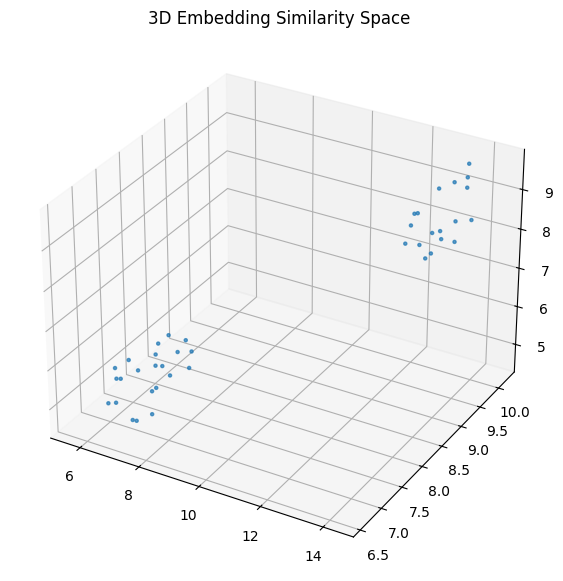

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    X_3d[:, 0],
    X_3d[:, 1],
    X_3d[:, 2],
    s=5,
    alpha=0.7
)

ax.set_title("3D Embedding Similarity Space")
plt.show()


In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

TOP_K = 5
sim = cosine_similarity(X)

neighbors = {
    i: np.argsort(sim[i])[::-1][1:TOP_K+1]
    for i in range(len(X))
}


In [18]:
import numpy as np

X = np.array(embeddings)


In [19]:
import umap

reducer = umap.UMAP(
    n_components=3,
    random_state=42,
    metric="cosine"
)

X_3d = reducer.fit_transform(X)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [20]:
from sklearn.metrics.pairwise import cosine_similarity

TOP_K = 5

similarity_matrix = cosine_similarity(X)

neighbors = {
    i: np.argsort(similarity_matrix[i])[::-1][1:TOP_K+1]
    for i in range(len(X))
}


In [25]:
edge_x, edge_y, edge_z = [], [], []

for i, nbrs in neighbors.items():
    for j in nbrs:
        edge_x += [X_3d[i, 0], X_3d[j, 0], None]
        edge_y += [X_3d[i, 1], X_3d[j, 1], None]
        edge_z += [X_3d[i, 2], X_3d[j, 2], None]


In [29]:
import plotly.graph_objects as go

fig = go.Figure()

# Nodes
fig.add_trace(
    go.Scatter3d(
        x=X_3d[:, 0],
        y=X_3d[:, 1],
        z=X_3d[:, 2],
        mode="markers",
        marker=dict(size=4, color="lightblue", opacity=0.7),
        text=texts,
        hoverinfo="text",
        name="Chunks"
    )
)

# Edges
fig.add_trace(
    go.Scatter3d(
        x=edge_x,
        y=edge_y,
        z=edge_z,
        mode="lines",
        line=dict(width=1),
        opacity=0.4,
        name="Semantic Neighbors"
    )
)

fig.update_layout(
    title="Semantic Embedding Space (Colab)",
    scene=dict(
        xaxis_title="UMAP-1",
        yaxis_title="UMAP-2",
        zaxis_title="UMAP-3"
    )
)

fig.show()


In [30]:
!pip install rank-bm25==0.2.2


In [32]:
# === FULL TRACEABLE HYBRID RAG ===
# Shows:
# 1) Initial BM25 + Vector chunks
# 2) Reranked chunks (Stage 2)
# 3) Final answer with citations
# 4) Exact chunk text behind [1], [2], ...

from langchain_community.retrievers import BM25Retriever
from sentence_transformers import CrossEncoder
import numpy as np
from textwrap import shorten

# -------------------------------
# Setup Retrievers
# -------------------------------
bm25 = BM25Retriever.from_documents(chunks)
bm25.k = 20

vector_retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 20}
)

reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

# -------------------------------
# Hybrid Retrieval + Debug
# -------------------------------
def hybrid_rag_with_trace(query, final_k=4):
    # ---- Stage 1: Retrieval ----
    bm25_docs = bm25.get_relevant_documents(query)
    vec_docs = vector_retriever.get_relevant_documents(query)

    stage1_docs = []
    seen = set()

    for d in bm25_docs + vec_docs:
        h = hash(d.page_content)
        if h not in seen:
            seen.add(h)
            stage1_docs.append(d)

    # ---- Stage 2: Reranking ----
    pairs = [[query, d.page_content] for d in stage1_docs]
    scores = reranker.predict(pairs)

    ranked = sorted(
        zip(stage1_docs, scores),
        key=lambda x: x[1],
        reverse=True
    )

    stage2_docs = ranked[:final_k]

    # ---- Prompt with Citations ----
    context = "\n\n".join(
        f"[{i+1}] {doc.page_content}"
        for i, (doc, _) in enumerate(stage2_docs)
    )

    prompt = f"""
Answer ONLY using the context below.
Cite every sentence using [1], [2], etc.
If the answer is not present, say "Not found in documents."

Context:
{context}

Question:
{query}
"""

    response = llm.invoke(prompt)

    confidence = float(np.mean([score for _, score in stage2_docs]))

    return {
        "answer": response.content,
        "confidence": confidence,
        "stage1_docs": stage1_docs,
        "stage2_docs": stage2_docs
    }

# -------------------------------
# RUN QUERY
# -------------------------------
query = "Summarize the key points of this document."

result = hybrid_rag_with_trace(query)

# -------------------------------
# OUTPUT SECTION
# -------------------------------

print("\n==================== FINAL ANSWER ====================")
print(result["answer"])
print("\nConfidence Score:", round(result["confidence"], 3))

print("\n==================== STAGE 1: INITIAL RETRIEVAL ====================")
print(f"Total Chunks Retrieved (BM25 + Vector): {len(result['stage1_docs'])}\n")

for i, doc in enumerate(result["stage1_docs"], 1):
    print(f"[S1-{i}] {shorten(doc.page_content, 300)}")

print("\n==================== STAGE 2: RERANKED (FINAL CONTEXT) ====================")

for i, (doc, score) in enumerate(result["stage2_docs"], 1):
    print(f"\n[{i}] Reranker Score: {round(score, 4)}")
    print(doc.page_content)

print("\n==================== CITATION MAP ====================")
for i, (doc, _) in enumerate(result["stage2_docs"], 1):
    print(f"\nCitation [{i}] refers to:")
    print(shorten(doc.page_content, 500))



==================== FINAL ANSWER ====================
The document discusses the Hough Transform for Line Fitting, which is a technique used to determine lines from points and vote for possible lines based on edge points [1]. It also includes numerical examples of determining if points lie on the same line using the Hough transformation formula [2][3]. The challenges in line fitting include dealing with extra edge points, multiple models, missing evidence, and noise in measured edge points [4].

Confidence Score: -9.489

==================== STAGE 1: INITIAL RETRIEVAL ====================
Total Chunks Retrieved (BM25 + Vector): 30

[S1-1] RoleofVotinginLineFitting•It’snotfeasibletocheckallcombinationsoffeaturesbyfittingamodeltoeachpossiblesubset.•Votingisageneraltechniquewhereweletthe featuresvoteforallmodelsthatarecompatible withit.–Cyclethroughfeatures,castvotesformodel [...]
[S1-2] Thankyou 40
[S1-3] NumericalsDetermineif(1,2),(2,3)and(3,4)areinthesamelineusingHoughtransformationy